In [87]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import pow
from random import random
import pandas
import pandas_datareader as pdr
from datetime import datetime
import operator
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tnrange, tqdm_notebook
import itertools
import time
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

def read_csv(filename,folder):
    folder=folder+"/"+filename+".csv"
    return pandas.read_csv(folder,encoding='ISO-8859-1')

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pandas.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pandas.concat(cols, axis=1)
	agg.columns = names
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression(fit_intercept = True)
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

def collect(target,fileName,start_date,end_date):
    pandas_source = []
    columns = []
    for item in target:
        try:
            name = ''.join(e for e in item if e.isalnum())
            if item == "VFINX":
                pandas_source.append(pdr.get_data_yahoo(symbols=item, start=start_date, end=end_date)["Adj Close"])
                columns.append(name)
            else:
                pandas_source.append(pdr.get_data_yahoo(symbols=item, start=start_date, end=end_date)["Adj Close"])
                columns.append(name)
                pandas_source.append(pdr.get_data_yahoo(symbols=item, start=start_date, end=end_date)["Open"])
                columns.append(name+" Open")
                pandas_source.append(pdr.get_data_yahoo(symbols=item, start=start_date, end=end_date)["Close"])
                columns.append(name+" Close")
                pandas_source.append(pdr.get_data_yahoo(symbols=item, start=start_date, end=end_date)["Adj Close"].pct_change())
                columns.append(name+" change")
                if name != "SP500TR":
                    if name != "vix":
                        pandas_source.append(pdr.get_data_yahoo(symbols=item, start=start_date, end=end_date)["Volume"])
                        columns.append(name+" volume")
        except:
            print("Skip ",item)

    bnp = pandas.concat(pandas_source, axis=1)
    bnp.columns = np.array(columns)
    bnp = bnp.sort_values(by="Date",ascending=True)
    bnp = bnp.fillna(method='ffill')
    bnp.dropna(inplace=True)
    bnp.to_csv('%s.csv' % (fileName))


In [88]:
start_date = datetime(2000, 1, 1)
end_date = datetime(2019, 9, 29)
series_day = 3
kfolder_num = 5

predict_start_date = datetime(2019, 9, 30-series_day-2)
predict_end_date = datetime(2020, 9, 30)


# 2019/9/30 - 2020/9/30
target = ['VFINX','^SP500TR','^vix','DX-Y.NYB','AAPL','MSFT','GOOGL','GOOG','BRK-B','FB','JNJ','PG','V']
collect(target,'train',start_date,end_date)
collect(target,'predict',predict_start_date,predict_end_date)

In [89]:
data=read_csv(filename="train",folder="./")
data = data.dropna().drop('Date', axis=1)
data.head()

,VFINX,SP500TR,SP500TR Open,SP500TR Close,SP500TR change,vix,vix Open,vix Close,vix change,DXYNYB,...,PG,PG Open,PG Close,PG change,PG volume,V,V Open,V Close,V change,V volume
0,103.465073,2278.239990,2242.250000,2278.239990,0.016051,22.010000,24.879999,22.010000,-0.123108,81.080002,...,48.844662,63.660000,63.389999,-0.002047,9553100.0,27.303270,28.317499,29.055000,0.031783,13272000.0
1,103.516098,2279.399902,2278.419922,2279.399902,0.000509,22.480000,21.760000,22.480000,0.021354,81.669998,...,48.659744,63.430000,63.150002,-0.003786,7535500.0,27.813066,29.102501,29.597500,0.018672,18594400.0
2,103.694748,2283.360107,2279.409912,2283.360107,0.001737,22.330000,23.320000,22.330000,-0.006673,82.089996,...,48.074120,63.000000,62.389999,-0.012035,13765400.0,27.996300,29.405001,29.792500,0.006588,16558000.0
3,103.856400,2286.870117,2283.120117,2286.870117,0.001537,21.540001,22.000000,21.540001,-0.035378,82.290001,...,48.212833,62.490002,62.570000,0.002885,9178100.0,28.137262,29.930000,29.942499,0.005035,12749600.0
4,103.635193,2281.919922,2287.090088,2281.919922,-0.002165,21.760000,22.049999,21.760000,0.010214,82.400002,...,48.151184,62.580002,62.490002,-0.001279,7377700.0,28.043293,29.847500,29.842501,-0.003340,11780000.0


In [90]:
reframed = series_to_supervised(data, series_day, 1)
drop_cols = list(filter(lambda s:'(t)' in s,reframed.columns))
prediction_cols = list(filter(lambda s:'var1(t)' in s,reframed.columns))
Y = reframed[prediction_cols[0]]
for item in drop_cols:
    reframed = reframed.drop(columns = item, axis = 1)
X = reframed

Observations: 618
Training Observations: 310
Testing Observations: 308


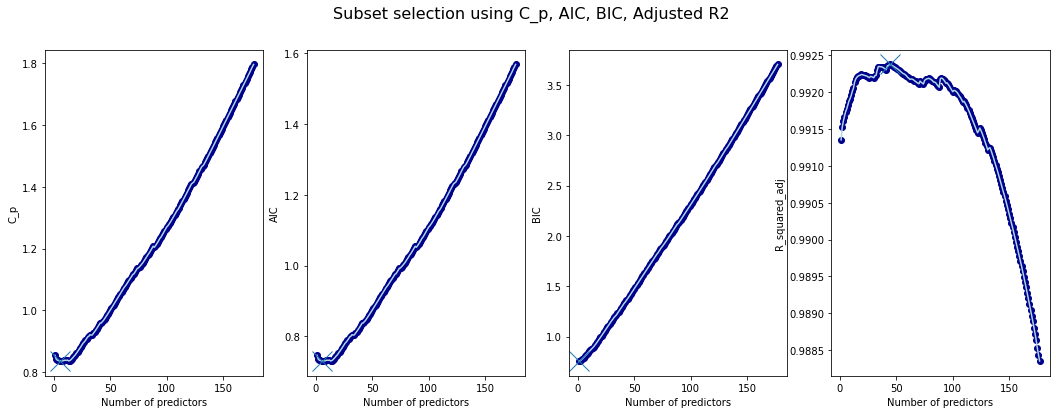

      features         RSS  R_squared  numb_features       C_p       AIC  \
1  [var2(t-1)]  262.591698   0.991381              1  0.854458  0.746184   

        BIC  R_squared_adj  
1  0.758237       0.991353  
0.7301620020427609
1    [var2(t-1)]
Name: features, dtype: object
Test RMSE: 1.040
------------------------------
Observations: 926
Training Observations: 618
Testing Observations: 308


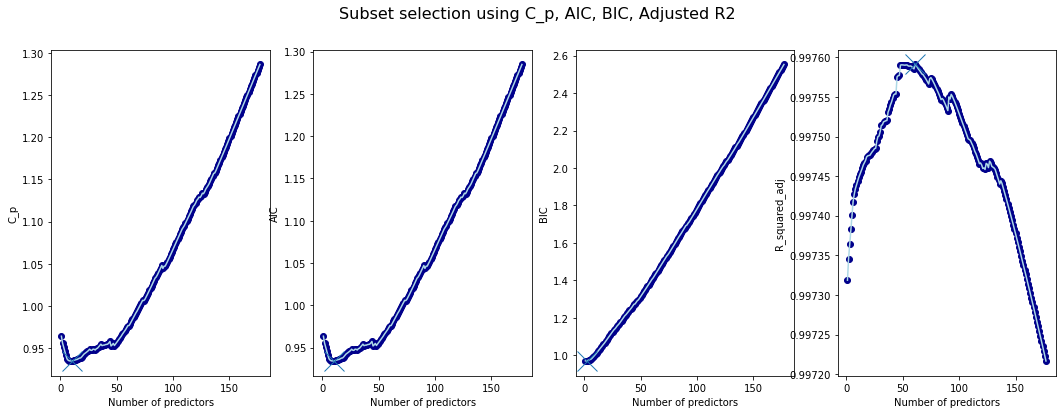

                 features         RSS  R_squared  numb_features       C_p  \
2  [var2(t-1), var7(t-3)]  587.055965   0.997355              2  0.956408   

        AIC      BIC  R_squared_adj  
2  0.955414  0.96974       0.997346  
0.9342379991315872
2    [var2(t-1), var7(t-3)]
Name: features, dtype: object
Test RMSE: 1.705
------------------------------
Observations: 1234
Training Observations: 926
Testing Observations: 308


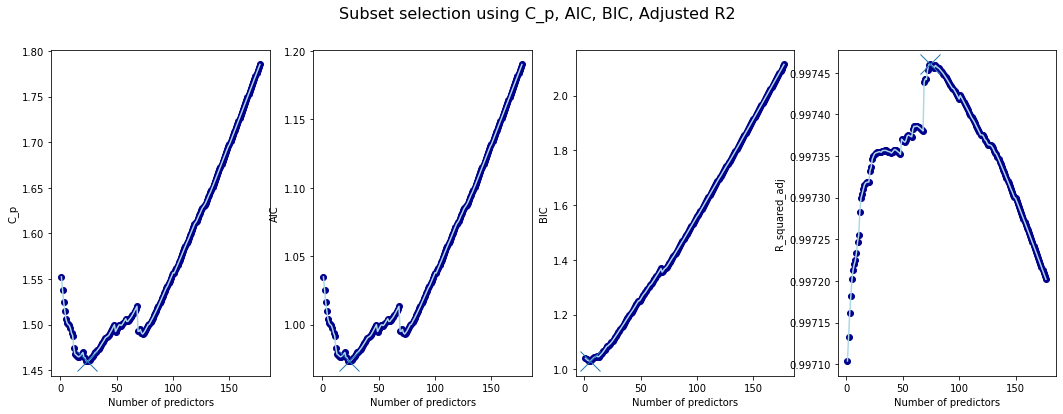

                                            features          RSS  R_squared  \
5  [var1(t-1), var6(t-2), var20(t-1), var21(t-1),...  1380.003114   0.997217   

   numb_features       C_p       AIC       BIC  R_squared_adj  
5              5  1.506483  1.004295  1.030379       0.997202  
0.9734981972389117
5    [var1(t-1), var6(t-2), var20(t-1), var21(t-1),...
Name: features, dtype: object
Test RMSE: 1.526
------------------------------
Observations: 1542
Training Observations: 1234
Testing Observations: 308


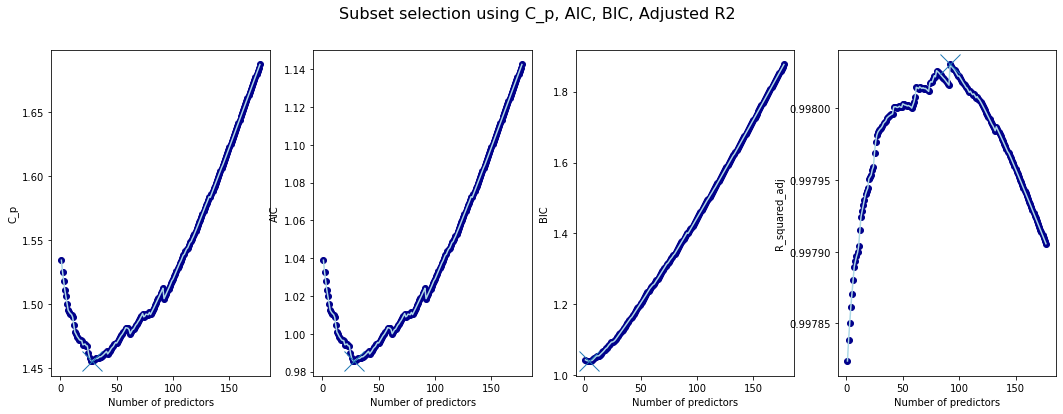

                                         features          RSS  R_squared  \
4  [var2(t-1), var36(t-1), var6(t-3), var14(t-3)]  1852.953786   0.997869   

   numb_features       C_p       AIC       BIC  R_squared_adj  
4              4  1.511157  1.023319  1.039909       0.997862  
0.9855824949343359
4    [var2(t-1), var36(t-1), var6(t-3), var14(t-3)]
Name: features, dtype: object
Test RMSE: 1.745
------------------------------
Observations: 1850
Training Observations: 1542
Testing Observations: 308


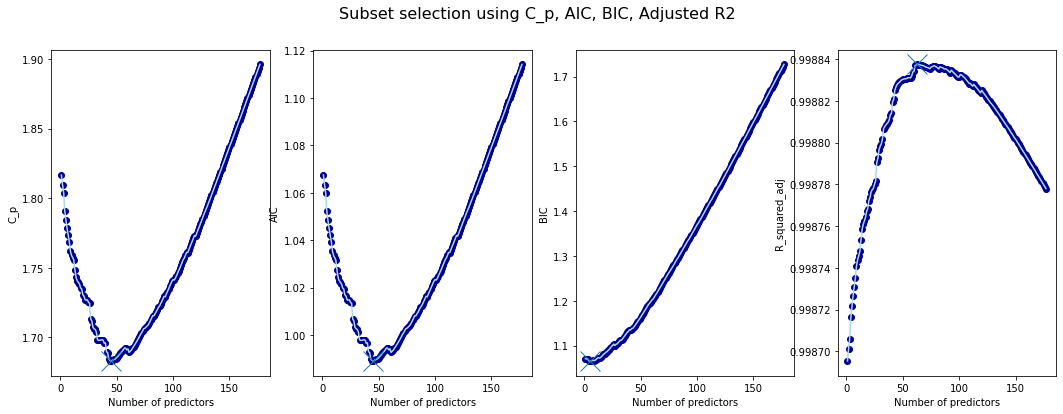

                                            features          RSS  R_squared  \
5  [var2(t-1), var9(t-3), var36(t-2), var35(t-1),...  2734.246379   0.998726   

   numb_features       C_p       AIC       BIC  R_squared_adj  
5              5  1.784218  1.048443  1.065761       0.998722  
0.9890248182830076
5    [var2(t-1), var9(t-3), var36(t-2), var35(t-1),...
Name: features, dtype: object
Test RMSE: 2.398
------------------------------
Done


In [91]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

seriesReframed = pandas.concat([reframed,Y],axis=1)
seriesReframed.head()

X = seriesReframed.values
splits = TimeSeriesSplit(n_splits=kfolder_num)

min_rmse = 100.0
best_model_aic = 100.0
best_model = linear_model.LinearRegression(fit_intercept = True)
best_select_feature = ''

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X , test_y  = test[:, :-1], test[:, -1]
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    observation = len(train) + len(test)
    print('Observations: %d' % (observation))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d' % (len(test)))
    
    subset = seriesReframed[0:len(train)]
    drop_cols = list(filter(lambda s:'(t)' in s,subset.columns))
    prediction_cols = list(filter(lambda s:'var1(t)' in s,subset.columns))
    subsetY = subset[prediction_cols[0]]
    for item in drop_cols:
        subset = subset.drop(columns = item, axis = 1)
    subsetX = subset
    
    k = len(subsetX.columns.values)
    RSS_list, R_squared_list, feature_list = [],[], []
    numb_features = []

    remaining_features = list(subsetX.columns.values)
    features = []
    RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
    features_list = {}

    for i in range(1,k+1):
        best_RSS = np.inf
        for combo in itertools.combinations(remaining_features,1):
                RSS = fit_linear_reg(subsetX[list(combo) + features],subsetY)   #Store temp result 
                if RSS[0] < best_RSS:
                    best_RSS = RSS[0]
                    best_R_squared = RSS[1] 
                    best_feature = combo[0]
        #Updating variables for next loop
        features.append(best_feature)
        remaining_features.remove(best_feature)
        #Saving values for plotting
        RSS_list.append(best_RSS)
        R_squared_list.append(best_R_squared)
        features_list[i] = features.copy()

    df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
    df1['numb_features'] = df1.index
    #Initializing useful variables
    m = len(subsetY)
    p = len(subsetX.columns.values)
    hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

    #Computing
    df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
    df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
    df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
    df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
#     print(df1)
    
    variables = ['C_p', 'AIC','BIC','R_squared_adj']
    fig = plt.figure(figsize = (18,6))

    for i,v in enumerate(variables):
        ax = fig.add_subplot(1, 4, i+1)
        ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
        ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
        if v == 'R_squared_adj':
            ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
        else:
            ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
        ax.set_xlabel('Number of predictors')
        ax.set_ylabel(v)

    fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
    plt.show()
    
    selectFeature = df1.loc[df1['BIC'] == df1['BIC'].min()].features
    selectFeatureAIC = df1.loc[df1['BIC'] == df1['BIC'].min()].AIC

    print(df1.loc[df1['BIC'] == df1['BIC'].min()])
    print(df1['AIC'].min())
    print(selectFeature)
    
    allset = seriesReframed[0:observation]
    prediction_cols = list(filter(lambda s:'var1(t)' in s,allset.columns))
    allsetY = allset[prediction_cols[0]]
    
    for item in allset.columns:
        if item.strip() not in str(selectFeature).strip(): 
            allset = allset.drop(columns = item, axis = 1)
    trainsubset = pandas.concat([allset,allsetY],axis=1)
    
    
    train = trainsubset.values[train_index]
    test = trainsubset.values[test_index]
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X , test_y  = test[:, :-1], test[:, -1]
    train_X.shape, train_y.shape, test_X.shape, test_y.shape
    model = linear_model.LinearRegression(fit_intercept = True)
    history = model.fit(train_X,train_y)
    yhat = model.predict(test_X)
    real = test_y.reshape((len(test_y), 1))
    rmse = sqrt(mean_squared_error(real, yhat))
    print('Test RMSE: %.3f' % rmse)
    if min_rmse > rmse:
        min_rmse = rmse
        best_model = model
        best_select_feature = str(selectFeature).strip()
        best_model_aic = selectFeatureAIC
    print('------------------------------')
print('Done')

  




In [92]:
# predict
predict_data=read_csv(filename="predict",folder="./")
predict_date_cols = list(filter(lambda s:'Date' in s,predict_data.columns))
Date_cols = predict_data[predict_date_cols[0]]

predict_data = predict_data.dropna().drop('Date', axis=1)
predict_data.head()

,VFINX,SP500TR,SP500TR Open,SP500TR Close,SP500TR change,vix,vix Open,vix Close,vix change,DXYNYB,...,PG,PG Open,PG Close,PG change,PG volume,V,V Open,V Close,V change,V volume
0,270.635437,6023.459961,5990.120117,6023.459961,0.006160,15.960000,17.049999,15.960000,-0.063930,99.040001,...,119.292831,123.559998,123.019997,-0.004773,5812600.0,173.916382,173.800003,175.279999,0.004585,7797300.0
1,269.996704,6009.189941,6025.560059,6009.189941,-0.002369,16.070000,16.230000,16.070000,0.006892,99.209999,...,120.543747,123.639999,124.309998,0.010486,6984800.0,174.283493,175.649994,175.649994,0.002111,10419000.0
2,268.591461,5978.109863,6025.890137,5978.109863,-0.005172,17.219999,15.770000,17.219999,0.071562,99.110001,...,120.795868,124.410004,124.570000,0.002092,5589800.0,172.646362,176.699997,174.000000,-0.009393,9212600.0
3,269.957397,6008.589844,5989.080078,6008.589844,0.005099,16.240000,17.230000,16.240000,-0.056911,99.379997,...,120.611626,124.570000,124.379997,-0.001525,5206900.0,170.671829,174.169998,172.009995,-0.011437,16464000.0
4,266.665375,5935.200195,6022.890137,5935.200195,-0.012214,18.559999,16.020000,18.559999,0.142857,99.129997,...,120.097687,124.360001,123.849998,-0.004261,5415700.0,172.934082,173.020004,174.289993,0.013255,8146200.0


In [93]:
print(min_rmse)
print(best_model)
print(best_select_feature)

1.0403558415918732
LinearRegression()
1    [var2(t-1)]
Name: features, dtype: object


RMS：29.40914557607107
RMSE：5.423019968253028
R^2：0.9449542240010852


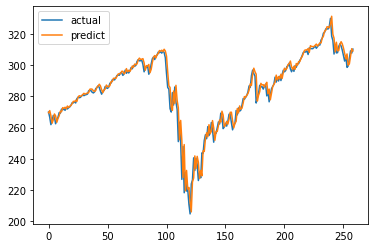

In [94]:

reframed = series_to_supervised(predict_data, series_day, 1)

y_cols = list(filter(lambda s:'var1(t)' in s,reframed.columns))
Y = reframed[y_cols[0]]

drop_cols = list(filter(lambda s:'(t)' in s,reframed.columns))
for item in drop_cols:
    reframed = reframed.drop(columns = item, axis = 1)

for item in reframed.columns:
    if item.strip() not in best_select_feature: 
        reframed = reframed.drop(columns = item, axis = 1)

reframed = pandas.concat([reframed,Y],axis=1)

test_X , test_y  = reframed.values[:, :-1], reframed.values[:, -1]
yhat = best_model.predict(test_X)
real = test_y.reshape((len(test_y), 1))
rmse = sqrt(mean_squared_error(real, yhat))

print(f"RMS：{mean_squared_error(real, yhat)}")
print(f"RMSE：{np.sqrt(mean_squared_error(real, yhat))}")
print(f"R^2：{r2_score(yhat, real)}")
plt.plot(real,label='actual')
plt.plot(yhat,label='predict')
plt.legend()
plt.show()


In [96]:
reframe = []
for item in real:
    reframe.append(item[0])
csvDict = {
    "Date": Date_cols[series_day:],
    "VFINX": reframe,
    "Prediction": yhat
}

csv = pd.DataFrame(csvDict)
csv.head()
csv.to_csv('mid.csv')